<a href="https://colab.research.google.com/github/ffabi/AssettoCorsaSelfDriving/blob/master/AssettoCorsaSelfDriving_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from sklearn import preprocessing
import random
from tensorflow import set_random_seed
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, BatchNormalization, pooling, MaxPooling2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam, SGD
import PIL
from PIL import Image
from keras.callbacks import EarlyStopping, ModelCheckpoint
import sys
import seaborn as sns 
from keras.preprocessing.image import img_to_array, load_img

# np.set_printoptions(threshold=np.nan)
np.set_printoptions(threshold=20)
np.random.seed(1234)
set_random_seed(1234)

In [133]:
from google.colab import drive 
drive.mount('/content/gdrive')

#change working directory to google drive
import os
os.chdir("/content/gdrive/My Drive/AssettoCorsaSelfDriving")

#enable importing python modules from the folder 'modules'
sys.path.append('modules')

img_shape = (73, 200, 3)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from PIL import Image

class LapRecognition:
    def __init__(self, threshold = 100):
        self.s1 = slice(134, 166)
        self.s2 = slice(1192, 1222)
        self.threshold = threshold
        
        self.number_one = img_to_array(load_img("modules/number_one.png"))
        
        
    def mse(self, imageA, imageB):
        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])
        return err
    

    def is_lap_one(self, image):
        difference = self.mse(image[self.s1, self.s2], self.number_one)
        return difference < self.threshold

In [0]:
import os, cv2
import PIL

class DataPreparation:
    def __init__(self, width, height) -> None:
        super().__init__()
       
        self.amount_of_frames = 0
        self.rec = LapRecognition(threshold=100)
        
        self.img_shape = (height, width, 3)
        

    def prepare(self, verbose = False):
        
        output = os.popen("ls dataset/videos | wc -l").read()
        amount_of_videos = int(output.replace("\n", ""))
        
        output = os.popen("ls dataset/metainfos | wc -l").read()
        amount_of_metafiles = int(output.replace("\n", ""))
        
        if verbose:
            print("Found", amount_of_videos, "videofiles and", amount_of_metafiles, "metafiles")
        
        amount_of_videos = min(amount_of_videos, amount_of_metafiles)
        
        datapoints = []
                
        for i in range(1, amount_of_videos+1):
            cap = cv2.VideoCapture("dataset/videos/" + str(i) + ".mp4")
            metafile = open("dataset/metainfos/"+ str(i) + ".txt")
            ret, frame = cap.read()
            
            videolength = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
            #read videofile until the start of the lap
            counter=0
            while not self.rec.is_lap_one(frame):
                ret, frame = cap.read()
                counter += 1
            if verbose:
                print("Found first frame of the first lap at", counter)
            
            videolength -= counter
            #reading while the first lap is recorded
            counter = 0
            while self.rec.is_lap_one(frame) and ret:
                values = metafile.readline().split(";")
                if len(values) < 2:
                    break
                
                datapoints.append((float(values[0]), self.amount_of_frames))

                img = cv2.resize(frame[250:], (self.img_shape[1], self.img_shape[0]))
                cv2.imwrite("dataset/resized_frames/frame_" + str(self.amount_of_frames) + ".png", img)
                self.amount_of_frames += 1

                if verbose:
                    cnt = int(counter/videolength*50)
                    sys.stdout.write('\r'+ "Processing " + str(i) + "/" + str(amount_of_videos) + " video: [" + "="*cnt + ">" + " "*(50-cnt-1) + "]")
                
                counter += 1
            
                ret, frame = cap.read()
            
            metafile.close()
            
            print("")
                
        return np.array(datapoints, dtype=[('data', np.float32, 1), ('frame', np.int16, 1)])



In [251]:
prep = DataPreparation(img_shape[1], img_shape[0])
dataset = prep.prepare(True)

Found 3 videofiles and 3 metafiles
Found first frame of the first lap at 223
Processing 1/3 video: [=================================================>]
Found first frame of the first lap at 173
Processing 2/3 video: [=================================================>]
Found first frame of the first lap at 38
Processing 3/3 video: [=================================================>]


In [0]:
!ls -lh dataset/resized_frames/* | grep "0 Jan"

In [0]:
!zip -rq dataset_resizedframes.zip dataset/resized_frames

In [258]:
np.save("dataset/serialized/dataset.npy", dataset)
!ls -lh dataset/serialized/dataset.npy

-rw------- 1 root root 63K Jan  9 12:34 dataset/serialized/dataset.npy


In [0]:
dataset = np.load("dataset/serialized/dataset.npy")

Size of dataset: 10587
Example data: (2.7661796, 4649)


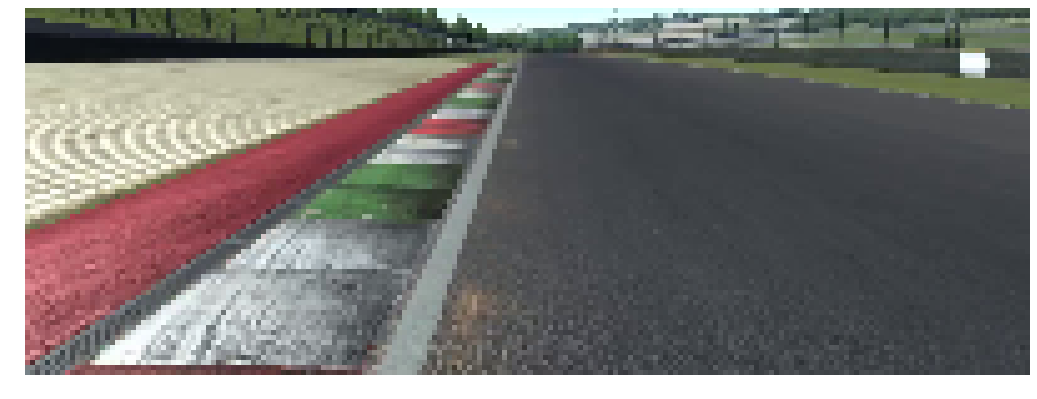

In [261]:
np.random.shuffle(dataset)
print("Size of dataset:", len(dataset))
print("Example data:", dataset[0])

img = Image.open("dataset/resized_frames/frame_" + str(dataset[0][1]) + ".png")
fig=plt.figure(figsize=(18, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

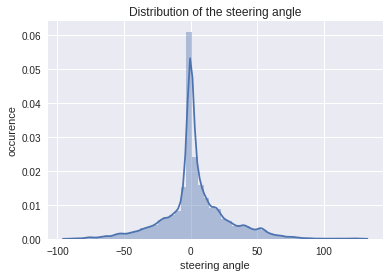

In [260]:
ax = sns.distplot(dataset["data"]);
ax.set(xlabel="steering angle", ylabel="occurence", title="Distribution of the steering angle")
plt.show()

In [262]:
valid_split = 0.2
test_split = 0.1
framecounter = len(dataset)

train = dataset[0:int(framecounter*(1-valid_split-test_split))]
valid = dataset[int(framecounter*(1-valid_split-test_split)):int(framecounter*(1-test_split))]
test  = dataset[int(framecounter*(1-test_split)):]

print("Number of train samples: ", len(train))
print("Example train data before minmax scaling:", train[0])
train_scale = train["data"].reshape(-1, 1)
valid_scale = valid["data"].reshape(-1, 1)
test_scale = test["data"].reshape(-1, 1)

#standard scaler
scaler = preprocessing.MinMaxScaler().fit(train_scale)
train["data"] = scaler.transform(train_scale).reshape(1, -1)
valid["data"] = scaler.transform(valid_scale).reshape(1, -1)
test["data"] = scaler.transform(test_scale).reshape(1, -1)

print("Example train data after minmax scaling:", train[0])

Number of train samples:  7410
Example train data before minmax scaling: (2.7661796, 4649)
Example train data after minmax scaling: (0.4269781, 4649)


In [0]:
# https://keras.io/utils/#sequence
from skimage.io import imread
class SimpleDataGenerator(keras.utils.Sequence):
    
    # Here, `x_set` is list of ids
    # and `y_set` are the associated steering angles
    
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        
        images = np.array([ imread('dataset/resized_frames/frame_' + str(ID) + '.png') for ID in batch_x])
        return images, np.array(batch_y)

In [0]:
#own
# model = Sequential()

# activation = "relu"

# model.add(Conv2D(16, kernel_size=(5,5), strides=(2,2), activation=activation, input_shape=img_shape))
# model.add(BatchNormalization())
# model.add(Conv2D(32, kernel_size=(5,5), strides=(2,2), activation=activation))
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))
# model.add(BatchNormalization())
# model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=activation))
# model.add(BatchNormalization())
# model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation=activation))
# model.add(BatchNormalization())
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))

# model.add(Flatten())


# model.add(Dense(100, activation=activation))
# model.add(BatchNormalization())
# model.add(Dense(50, activation=activation))
# model.add(BatchNormalization())
# model.add(Dense(10, activation=activation))
# model.add(BatchNormalization())

# model.add(Dense(1, activation='sigmoid'))


In [0]:
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=img_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [0]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.8, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=sgd, loss="mse")
# model.summary()

In [266]:
# training_generator = DataGenerator(train, dim=img_shape, batch_size=16)
# validation_generator = DataGenerator(valid, dim=img_shape, batch_size=16)

training_generator = SimpleDataGenerator(train["frame"], train["data"], batch_size=16)
validation_generator = SimpleDataGenerator(valid["frame"], valid["data"], batch_size=16)


#setup early stopping
es = EarlyStopping(patience=10, verbose=1, min_delta=0.005)

#we are going to keep only the best model
mcp = ModelCheckpoint(filepath='model/weights/weights.hdf5', verbose=1, save_best_only=True)

# set parameters and start learning
history = model.fit_generator(
            generator=training_generator,
            validation_data=validation_generator,
            use_multiprocessing=False,
            epochs=100, # early stopping detects the end
            verbose=1, 
            shuffle=True,
            callbacks=[mcp, es]
         )


Epoch 1/100
464/464 [==============================] - 47s 102ms/step - loss: 0.1988 - val_loss: 0.1970

Epoch 00001: val_loss improved from inf to 0.19703, saving model to model/weights/weights.hdf5
Epoch 2/100
464/464 [==============================] - 44s 96ms/step - loss: 0.0770 - val_loss: 0.0092

Epoch 00002: val_loss improved from 0.19703 to 0.00923, saving model to model/weights/weights.hdf5
Epoch 3/100
464/464 [==============================] - 45s 97ms/step - loss: 0.0080 - val_loss: 0.0072

Epoch 00003: val_loss improved from 0.00923 to 0.00718, saving model to model/weights/weights.hdf5
Epoch 4/100
464/464 [==============================] - 45s 96ms/step - loss: 0.0061 - val_loss: 0.0066

Epoch 00004: val_loss improved from 0.00718 to 0.00661, saving model to model/weights/weights.hdf5
Epoch 5/100
464/464 [==============================] - 45s 98ms/step - loss: 0.0052 - val_loss: 0.0057

Epoch 00005: val_loss improved from 0.00661 to 0.00575, saving model to model/weights/w

In [0]:
# load back best model (early stopping + model checkpoint)
model = load_model('model/weights/weights.hdf5')

In [0]:
def plot_history(network_history):
    
    #set pltting attributes
    #loss-epochs
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    #accuracy-epochs
#     plt.figure()
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.plot(network_history.history['acc'])
#     plt.plot(network_history.history['val_acc'])
#     plt.legend(['Training', 'Validation'])
    
    plt.show()

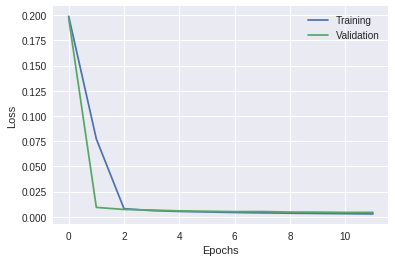

Test loss:  0.004314651410249295


In [269]:
#plot learning history
plot_history(history)

# Final evaluation of the model
test_generator = SimpleDataGenerator(test["frame"], test["data"], batch_size=16)
scores = model.evaluate_generator(test_generator, verbose=0)
print("Test loss: ", scores)
# print("Test accuracy: %.2f%%" % (scores[2]*100))

In [0]:
# dataset = np.load("dataset/serialized/dataset.npy")

# for i in range(200, 600):
#     img = np.array(cv2.imread("dataset/resized_frames/frame_" + str(i) + ".png", cv2.IMREAD_COLOR), copy=False, ndmin=4)
#     print(i, " prediction: ", scaler.inverse_transform(model.predict(img))[0][0], " ground truth: ", dataset["data"][i])

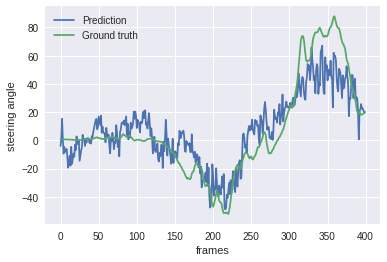

In [274]:
dataset = np.load("dataset/serialized/dataset.npy")

nb_predictions = 400
start = random.randint(0,len(dataset) - 401)

predictions = []

for i in range(start, start+nb_predictions):
    img = np.array(cv2.imread("dataset/resized_frames/frame_" + str(i) + ".png", cv2.IMREAD_COLOR), copy=False, ndmin=4)
    predictions.append(scaler.inverse_transform(model.predict(img))[0][0])
    
plt.figure()
plt.xlabel('frames')
plt.ylabel('steering angle')
plt.plot(predictions)
plt.plot(dataset["data"][start:start+nb_predictions])
plt.legend(['Prediction', 'Ground truth'])